In [1]:
from soursop.sstrajectory import parallel_load_trjs
from soursop.sstrajectory import SSTrajectory
import matplotlib.pyplot as plt
from starling.utilities import symmetrize_distance_maps
import numpy as np
from starling.models.vae import VAE
import torch
from einops import rearrange
import h5py
import hdf5plugin

In [3]:
def load_hdf5_data(file_path):
    """
    Loads data from an HDF5 file and returns the distance maps.

    Parameters:
    - file_path (str): Path to the HDF5 file.

    Returns:
    - numpy.ndarray: Distance maps loaded from the file.
    """
    with h5py.File(file_path, "r") as f:
        # Assuming the dataset is named 'distance_maps'
        if 'dm' in f:
            data = f['dm'][:]
            return data
        else:
            raise KeyError("Dataset 'distance_maps' not found in the HDF5 file.")

def encode_data(model, data):
    """
    Encodes data using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 64
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    encoded_batches = []
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            encoded_batch = model.encode(batch_tensor).sample()
            
            encoded_batches.append(encoded_batch.cpu().numpy())

            # Optional: clear GPU memory (only if memory issues occur)
            # torch.cuda.empty_cache()

    # Concatenate all batches
    encoded_data = np.concatenate(encoded_batches, axis=0).squeeze()

    return encoded_data


def decode_data(model, data):
    """
    Decodes data using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 64
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    decoded_batches = []
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            encoded_batch = model.encode(batch_tensor).sample()
            decoded_batch = model.decode(encoded_batch)
            
            decoded_batches.append(decoded_batch.cpu().numpy())

            # Optional: clear GPU memory (only if memory issues occur)
            # torch.cuda.empty_cache()

    # Concatenate all batches
    decoded_data = np.concatenate(decoded_batches, axis=0).squeeze()

    return decoded_data


preprint_VAE = VAE.load_from_checkpoint(
    "/home/borna/.starling_weights/model-kernel-epoch=99-epoch_val_loss=1.72.ckpt",
    map_location="cuda",
)
preprint_VAE.eval()

new_model_1e6 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/preprint_VAE_cont_training_KLD_1e6/model-kernel-epoch=11-epoch_val_loss=1.87.ckpt",
    map_location="cuda",
)
new_model_1e6.eval()

new_model_1e5 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/preprint_VAE_cont_training_KLD_1e5/model-kernel-epoch=07-epoch_val_loss=1.90.ckpt",
    map_location="cuda",
)
new_model_1e5.eval()

new_model_1e4 = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/vae_training/preprint_VAE_cont_training_KLD_1e4/model-kernel-epoch=09-epoch_val_loss=2.04.ckpt",
    map_location="cuda",
)
new_model_1e4.eval()


# model = VAE.load_from_checkpoint(
#     "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_Adam_kld_1e4_lr_1e3_instance_uniform_sampling/model-kernel-epoch=07-epoch_val_loss=2.05.ckpt",
#     map_location="cuda",
# )
# model.eval()

# model = VAE.load_from_checkpoint(
#     "/work/bnovak/projects/sequence2ensemble/vae_training/resnet18_Adam_kld_1e4_lr_5e4_instance_cont_uniform_sampling/model-kernel-epoch=00-epoch_val_loss=1.85.ckpt",
#     map_location="cuda",
# )
# model.eval()

/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.4.0


VAE(
  (encoder): ResNet_Encoder(
    (first_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (layer1): ModuleList(
      (0-1): 2 x ResBlockEncBasic(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation1): ReLU(inplace=True)
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (shortcut): Sequential()
        (activation): ReLU(inplace=True)
      )
    )
    (layer2): ModuleList(
      (0): ResBlockEncBasic(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm1): Instan

In [97]:
path = '/work/j.lotthammer/projects/diverse_disordered_seqs/long_synthetic_idrs/E6T1G9R8F9/1/'

topology = path + '__START.pdb'
traj = path + '__traj_pbcfix.xtc'

traj = SSTrajectory(traj, topology)

In [98]:
distance_maps = traj.proteinTrajectoryList[0].get_distance_map(
        verbose=False, stride=30, return_instantaneous_maps=True
    )[0]

In [99]:
distance_maps = symmetrize_distance_maps(distance_maps)
distance_maps = np.array(distance_maps, dtype=np.float32)

In [100]:
pad_h = 512 - distance_maps.shape[1]  # 9
pad_w = 512 - distance_maps.shape[2]  # 9

distance_maps_padded = np.pad(
    distance_maps,
    pad_width=((0,0), (0, pad_h), (0, pad_w)),
    mode='constant',
    constant_values=0
)

In [101]:
decoded_distance_maps = encode_data(model, distance_maps_padded)
decoded_distance_maps = symmetrize_distance_maps(decoded_distance_maps)
decoded_distance_maps = decoded_distance_maps[:, :512-pad_h, :512-pad_w]

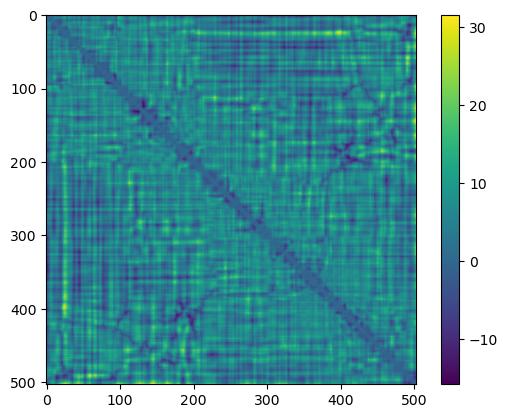

: 

In [ ]:
plt.imshow(distance_maps[0] - decoded_distance_maps[0])
plt.colorbar()

In [86]:
regular_dm_path = '/work/j.lotthammer/projects/diverse_disordered_seqs/long_synthetic_idrs/T6F9N1H6Y3/1/'

topology = regular_dm_path + '__START.pdb'
traj = regular_dm_path + '__traj_pbcfix.xtc'

traj = SSTrajectory(traj, topology)

In [87]:
distance_maps = traj.proteinTrajectoryList[0].get_distance_map(
        verbose=False, stride=30, return_instantaneous_maps=True
    )[0]

In [88]:
distance_maps = symmetrize_distance_maps(distance_maps)
distance_maps = np.array(distance_maps, dtype=np.float32)

In [89]:
pad_h = 384 - distance_maps.shape[1]  # 9
pad_w = 384 - distance_maps.shape[2]  # 9

distance_maps_padded = np.pad(
    distance_maps,
    pad_width=((0,0), (0, pad_h), (0, pad_w)),
    mode='constant',
    constant_values=0
)

In [91]:
decoded_distance_maps = encode_data(model, distance_maps_padded)
decoded_distance_maps = symmetrize_distance_maps(decoded_distance_maps)
decoded_distance_maps = decoded_distance_maps[:, :384-pad_h, :384-pad_w]

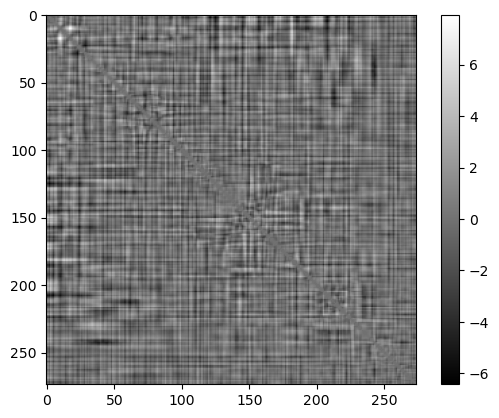

In [93]:
plt.imshow(distance_maps[10] - decoded_distance_maps[10], cmap='gray')
plt.colorbar()

In [4]:
import glob

files = glob.glob('/work/bnovak/projects/sequence2ensemble/lammps_data/150mM_data/mPIPIgg_70k_seqs/IDRs_0003/preprocessed_data/*h5')

files = [i for i in files if 'vae_encoded' not in i]

In [5]:
import glob

data = [load_hdf5_data(i) for i in files]

In [6]:
data = np.concatenate(data, axis=0)

In [7]:
preprint_encoded_data = encode_data(preprint_VAE, data)
new_encoded_data_1e6 = encode_data(new_model_1e6, data)
new_encoded_data_1e5 = encode_data(new_model_1e5, data)
new_encoded_data_1e4 = encode_data(new_model_1e4, data)

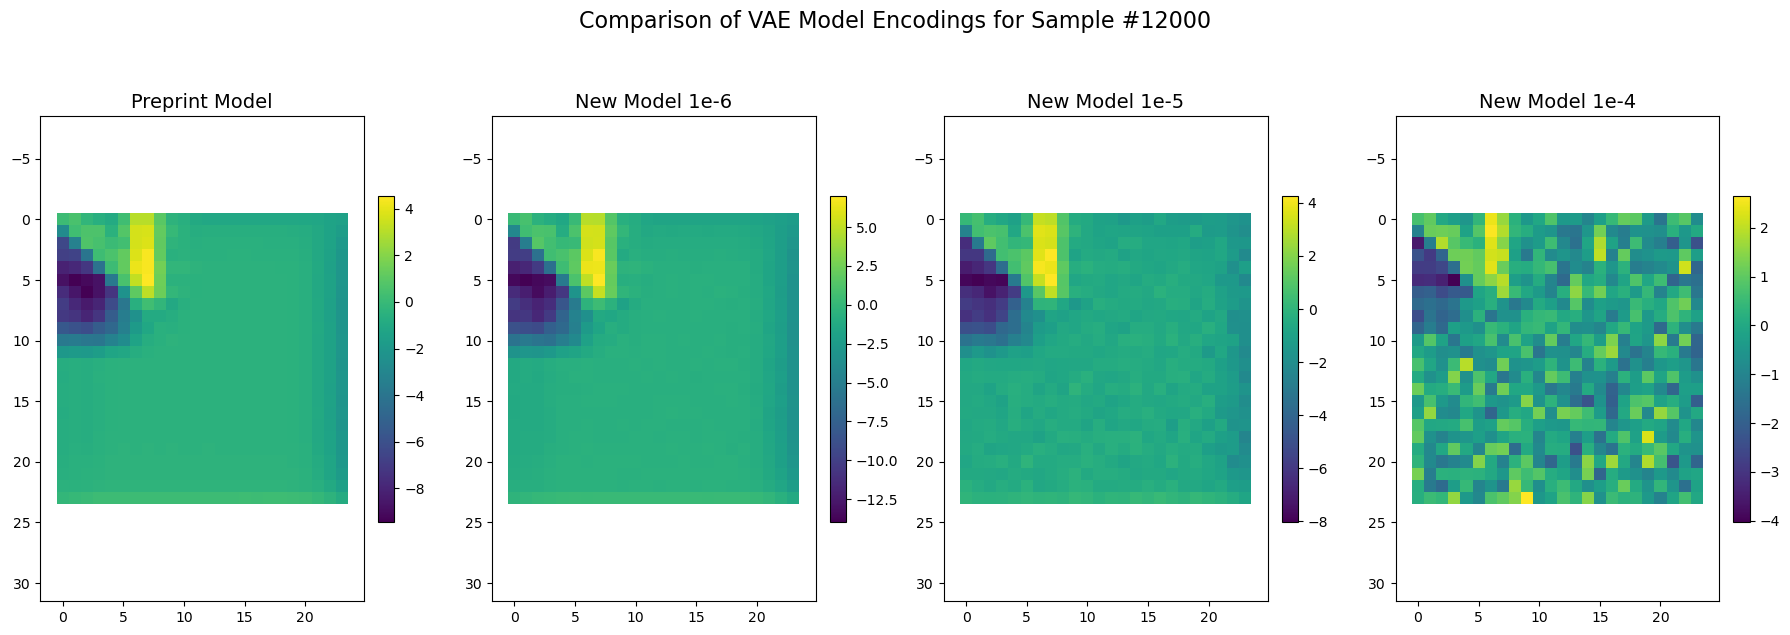

In [8]:
sample = 12000

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Plot image from preprint model
# Create histogram for new model (1e-4)
latent_space = preprint_encoded_data
# latent_space = (latent_space - latent_space.mean()) / latent_space.std()
im1 = axes[0].imshow(latent_space[sample], cmap='viridis')
axes[0].set_title('Preprint Model', fontsize=14)
axes[0].axis('equal')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot image from new model
latent_space = new_encoded_data_1e6
# latent_space = (latent_space - latent_space.mean()) / latent_space.std()
im2 = axes[1].imshow(latent_space[sample], cmap='viridis')
axes[1].set_title('New Model 1e-6', fontsize=14)
axes[1].axis('equal')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Plot image from new model
latent_space = new_encoded_data_1e5
# latent_space = (latent_space - latent_space.mean()) / latent_space.std()
im2 = axes[2].imshow(latent_space[sample], cmap='viridis')
axes[2].set_title('New Model 1e-5', fontsize=14)
axes[2].axis('equal')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# Plot difference between models
latent_space = new_encoded_data_1e4
# latent_space = (latent_space - latent_space.mean()) / latent_space.std()
im3 = axes[3].imshow(latent_space[sample], cmap='viridis')
axes[3].set_title('New Model 1e-4', fontsize=14)
axes[3].axis('equal')
fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

# Add overall title
plt.suptitle(f'Comparison of VAE Model Encodings for Sample #{sample}', fontsize=16, y=1.05)

# Ensure proper spacing
plt.tight_layout()

plt.show()

In [9]:
print('Preprint Mean', preprint_encoded_data.mean(), 'Std', preprint_encoded_data.std())

print('New Model Mean 1e-6', new_encoded_data_1e6.mean(), 'Std', new_encoded_data_1e6.std())

print('New Model Mean 1e-5', new_encoded_data_1e5.mean(), 'Std', new_encoded_data_1e5.std())

print('New Model Mean 1e-4', new_encoded_data_1e4.mean(), 'Std', new_encoded_data_1e4.std())

Preprint Mean -1.011186 Std 1.7509091
New Model Mean 1e-6 -1.5959681 Std 2.660442
New Model Mean 1e-5 -1.0589173 Std 1.7426931
New Model Mean 1e-4 -0.32229877 Std 1.0847311


/tmp/ipykernel_24034/2348803910.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[0].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_24034/2348803910.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_24034/2348803910.py:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axes[2].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
/tmp/ipykernel_24034/2348803910.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keywor

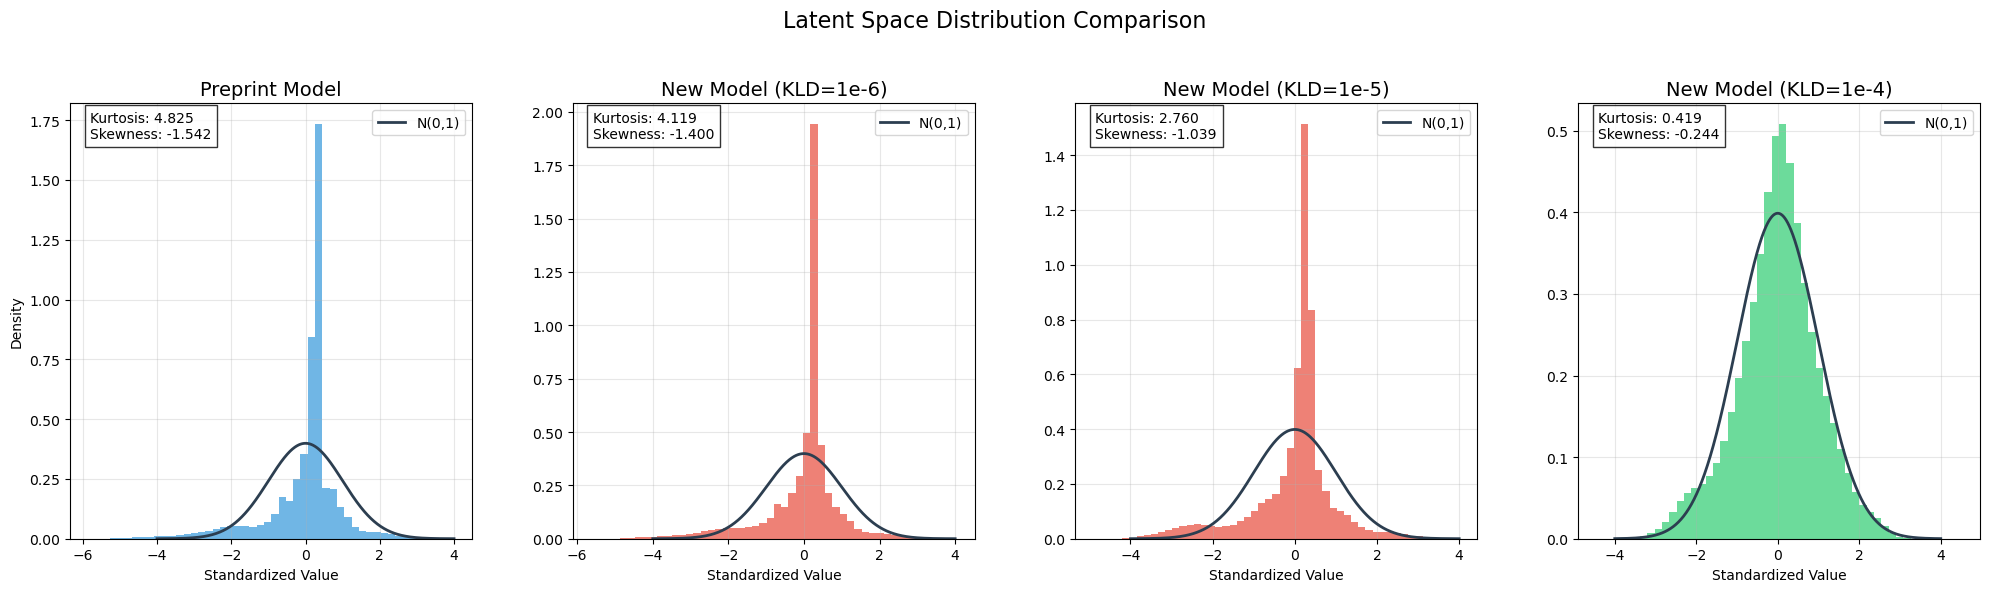

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from einops import rearrange

# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Latent Space Distribution Comparison', fontsize=16)

# Define a range for plotting the normal distribution
x = np.linspace(-4, 4, 1000)
normal_pdf = stats.norm.pdf(x)

# Create color palette
colors = ['#3498db', '#e74c3c', '#2ecc71']
line_color = '#2c3e50'

# Create histogram for preprint model
latent_space = preprint_encoded_data
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[0].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[0])
axes[0].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[0].set_title('Preprint Model', fontsize=14)
# axes[0].set_xlim(-4, 4)
axes[0].set_xlabel('Standardized Value')
axes[0].set_ylabel('Density')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Create histogram for new model (1e-6)
latent_space = new_encoded_data_1e6
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[1].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[1])
axes[1].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[1].set_title('New Model (KLD=1e-6)', fontsize=14)
# axes[1].set_xlim(-4, 4)
axes[1].set_xlabel('Standardized Value')
axes[1].grid(alpha=0.3)
axes[1].legend()

# Create histogram for new model (1e-5)
latent_space = new_encoded_data_1e5
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[2].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[1])
axes[2].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[2].set_title('New Model (KLD=1e-5)', fontsize=14)
# axes[1].set_xlim(-4, 4)
axes[2].set_xlabel('Standardized Value')
axes[2].grid(alpha=0.3)
axes[2].legend()

# Create histogram for new model (1e-4)
latent_space = new_encoded_data_1e4
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std()), "b h w -> (b h w)")

axes[3].hist(flattened, bins=50, alpha=0.7, density=True, color=colors[2])
axes[3].plot(x, normal_pdf, 'k-', linewidth=2, color=line_color, label='N(0,1)')
axes[3].set_title('New Model (KLD=1e-4)', fontsize=14)
# axes[2].set_xlim(-4, 4)
axes[3].set_xlabel('Standardized Value')
axes[3].grid(alpha=0.3)
axes[3].legend()

# Add statistical data
for i, (title, data) in enumerate([
    ("Preprint", preprint_encoded_data),
    ("New (1e-6)", new_encoded_data_1e6), 
    ("New (1e-5)", new_encoded_data_1e5), 
    ("New (1e-4)", new_encoded_data_1e4)
]):
    normalized = rearrange(((data - data.mean()) / data.std()), "b h w -> (b h w)")
    kurtosis = stats.kurtosis(normalized)
    skewness = stats.skew(normalized)
    axes[i].text(0.05, 0.92, f"Kurtosis: {kurtosis:.3f}\nSkewness: {skewness:.3f}", 
                transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the suptitle
plt.subplots_adjust(wspace=0.25)  # Add space between subplots

# # Save or display
# plt.savefig('latent_space_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
latent_space = new_encoded_data_1e4
flattened = rearrange(((latent_space - latent_space.mean()) / latent_space.std() ), "b h w -> (b h w)")

In [17]:
latent_space.shape

(64013, 24, 24)

In [46]:
test = np.random.normal(size=(1, 24, 24))

test = test + latent_space.mean()
test = test * latent_space.std()

In [47]:
test = torch.from_numpy(test).to('cuda').unsqueeze(0).to(torch.float32)

In [49]:
distance_map = new_model_1e4.decode(test).squeeze().detach().cpu().numpy()

1.3692181
1.3335315


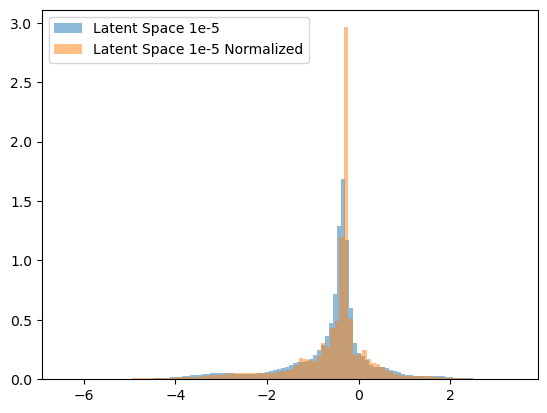

In [25]:
latent_space = new_encoded_data_1e5
latent_space = latent_space / latent_space.std()\

print(np.mean(latent_space**2))

plt.hist(latent_space.flatten(), bins=100, density=True, alpha=0.5, label='Latent Space 1e-5')

latent_space = preprint_encoded_data
latent_space = latent_space / latent_space.std()

print(np.mean(latent_space**2))

plt.hist(latent_space.flatten(), bins=100, density=True, alpha=0.5, label='Latent Space 1e-5 Normalized')

plt.legend()

plt.show()

In [14]:
latent_space.max()

3.1954641

In [16]:
latent_space.max()

3.8030968